# End of module project
PART 1 - Analysis of the data

Uses the tennis matches results data between 2020 and 2022 from http://tennis-data.co.uk/alldata.php



In [3]:
# do the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

# read data file
df = pd.read_csv('./2020-2022.csv')
df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Bublik A.,...,0.0,Completed,2.00,1.72,2.21,1.74,2.25,1.80,2.11,1.72
1,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,...,0.0,Completed,1.57,2.25,1.60,2.47,1.65,2.47,1.59,2.34
2,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,...,0.0,Completed,1.25,3.75,1.31,3.74,1.33,3.85,1.29,3.53
3,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,...,1.0,Completed,1.83,1.83,1.97,1.92,2.00,2.07,1.87,1.92
4,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,...,1.0,Completed,1.50,2.50,1.54,2.62,1.57,2.65,1.53,2.47


In [4]:
# drop the lines where there are no data in AvgW, AvgL, WRank or LRank
# we could use one of the existing odds (other than average) but given the limited number of lines dropped it's no issue
# for the ranks on the other hand we really need to have both players' rank (to compare) so we drop the line where one is missing
# hence dropping the lines for AvgW and AvgL is more simple too
numels = df.shape[0]
df = df.dropna(subset=['AvgW','AvgL','WRank','LRank'],axis=0)
print('Drop NA on AvgW, AvgL, WRank, LRank: ',numels-df.shape[0],' rows dropped')

# drop the lines where AvgW ou AvgL are dubious (more than 50% away from B365W / B365L)
# means there could be a mistake in either one (again, very limited number of rows)
numels = df.shape[0]
df = df.drop(df[df['AvgW']>1.5*df['B365W']].index,axis=0)
df = df.drop(df[df['AvgL']>1.5*df['B365L']].index,axis=0)
print('Drop dubious odds: ',numels-df.shape[0],' rows dropped')

df = df.reset_index(drop=True)

# compute delta rank (difference between winner and loser ranks)
df['DeltaRank'] = df['WRank']-df['LRank']

Drop NA on AvgW, AvgL, WRank, LRank:  15  rows dropped
Drop dubious odds:  10  rows dropped


## 0. How reliable are the odds?

In [11]:
def getOddsResult(df,diff):
    res = diff.copy()
    i=0
    for d in diff:
        df2 = df[abs(df['AvgL']-df['AvgW'])>d]
        ok = df2[df2['AvgW']<df2['AvgL']]
        res[i] = ok.size/df2.size*100
        i=i+1
    return(res)

In [13]:
# odds are ok if winner's was lower than loser's
# check results for all data
diff = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
res = getOddsResult(df,diff)
# check results for ATP250 tournaments
res250 = getOddsResult(df[df['Series']=="ATP250"],diff)
# check results for ATP500 tournaments
res500 = getOddsResult(df[df['Series']=="ATP500"],diff)
# check results for Masters 1000 tournaments
res1000 = getOddsResult(df[df['Series']=="Masters 1000"],diff)
# check results for Grand Slam tournaments
resGS = getOddsResult(df[df['Series']=="Grand Slam"],diff)

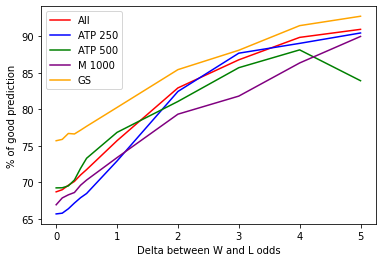

In [14]:
# show the results: rate of good prediction rate as a function of difference between odds
plt.plot(diff,res,color = 'red',label='All')
plt.plot(diff,res250,color = 'blue',label='ATP 250')
plt.plot(diff,res500,color = 'green',label='ATP 500')
plt.plot(diff,res1000,color = 'purple',label='M 1000')
plt.plot(diff,resGS,color = 'orange',label='GS')
plt.xlabel("Delta between W and L odds")
plt.ylabel("% of good prediction")
plt.legend()
plt.show()

Grand Slams stand clearly above the rest in terms of reliability of win prediction considering only the odds. This seems to be in accordance with classical expectations, as Grand Slams are the most important tournaments of the year and players really get ready for those.

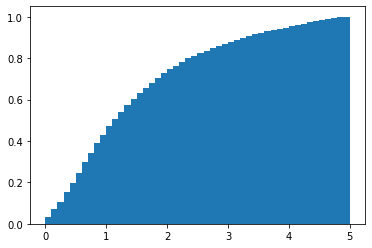

In [12]:
# check repartition of matches depending on difference in odds
subdf = df[abs(df['AvgL']-df['AvgW'])<=5]
plt.hist(abs(subdf['AvgL']-subdf['AvgW']),bins=50,cumulative=True,density=True)
plt.show()

### Focus on Grand slams tournaments (by round)

In [15]:
#  sdf -> GRand Slam tournaments
sdf = df[df['Series']=="Grand Slam"]

# check results for 1st round
resGS1 = getOddsResult(sdf[sdf['Round']=="1st Round"],diff)
# check results for 2nd Round
resGS2 = getOddsResult(sdf[sdf['Round']=="2nd Round"],diff)
# check results for 3rd Round
resGS3 = getOddsResult(sdf[sdf['Round']=="3rd Round"],diff)
# check results for 4th Round
resGS4 = getOddsResult(sdf[sdf['Round']=="4th Round"],diff)
# check results for Quarterfinals
resGS5 = getOddsResult(sdf[sdf['Round']=="Quarterfinals"],diff)
# check results for Semifinals
resGS6 = getOddsResult(sdf[sdf['Round']=="Semifinals"],diff)
# check results for The Final
resGS7 = getOddsResult(sdf[sdf['Round']=="The Final"],diff)

C:\Users\to200472\AppData\Local\Temp\ipykernel_4676\745194328.py:7: RuntimeWarning: invalid value encountered in long_scalars
  res[i] = ok.size/df2.size*100


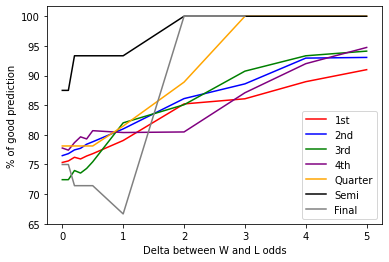

In [16]:
# plot the results
plt.plot(diff,resGS1,color = 'red',label='1st')
plt.plot(diff,resGS2,color = 'blue',label='2nd')
plt.plot(diff,resGS3,color = 'green',label='3rd')
plt.plot(diff,resGS4,color = 'purple',label='4th')
plt.plot(diff,resGS5,color = 'orange',label="Quarter")
plt.plot(diff,resGS6,color = 'black',label='Semi')
plt.plot(diff,resGS7,color = 'gray',label='Final')
plt.xlabel("Delta between W and L odds")
plt.ylabel("% of good prediction")
plt.legend()
plt.show()

Interestingly, we can notice then reliability is better from quarterfinals onwards, and first round is globally the less reliable (which seems logical)

### Grand Slams -> gains by match and by round

ALL MATCHES -> Simulate the gains if one was betting always according to the odds for each round

In [20]:
def getOddsGain(df,bet):
    gain = 0
    for i in df.index:
        if df['AvgW'][i]>df['AvgL'][i]:
            gain = gain+bet*(df['AvgW'][i]-1)
        else:
            gain = gain-bet
    return(gain,gain/df.shape[0])

In [25]:
# check results for all rounds
rounds = ["1st Round","2nd Round","3rd Round","4th Round","Quarterfinals","Semifinals","The Final"]
for round in rounds:
    gain,gainbymatch = getOddsGain(sdf[sdf['Round']==round],10)
    print("Gains in",round,": ",gain," - gain by match: ",gainbymatch)

Gains in 1st Round :  -872.6000000000004  - gain by match:  -1.7211045364891526
Gains in 2nd Round :  -511.4000000000001  - gain by match:  -2.0293650793650797
Gains in 3rd Round :  -137.3  - gain by match:  -1.0811023622047244
Gains in 4th Round :  -55.60000000000001  - gain by match:  -0.8825396825396826
Gains in Quarterfinals :  -119.10000000000001  - gain by match:  -3.7218750000000003
Gains in Semifinals :  -110.7  - gain by match:  -6.91875
Gains in The Final :  -24.0  - gain by match:  -3.0


SELECTED MATCHES -> Simulate the gains if one was betting always according to the odds for each round
here selection is betting on top 10 players when their oppoentn is lower ranked

In [27]:
thr = 10 # threshold for players ranking - 10 means we consider top 10 players
delta = 0 # delta is the ranking difference with the player's opponent - 0 means any player with higher ranking
series = "Grand Slam" # the type of tournament we consider

round = ["1st Round","2nd Round","3rd Round","4th Round","Quarterfinals","Semifinals","The Final"] 
gains = [0,0,0,0,0,0,0]
gainspermatch = [0,0,0,0,0,0,0]
roi = [0,0,0,0,0,0,0]
k=0
for r in round:
    subdf = df.loc[((df['WRank']<=thr) & (df['LRank']>df['WRank']+delta) & (df['Series']==series) & (df['Round']==r))]
    subdf = subdf.reset_index(drop=True)

    gain = 0
    nmatch = subdf.shape[0]
    print("win:",nmatch," average odds:",subdf['AvgW'].mean())
    for i in range(subdf.shape[0]):
        gain = gain+10*(subdf['AvgW'][i]-1)

    subdf = df.loc[((df['LRank']<=thr) & (df['WRank']>df['LRank']+delta) & (df['Series']==series) & (df['Round']==r))]
    print("loss:",subdf.shape[0]," average odds:",subdf['AvgW'].mean())
    nmatch = nmatch+subdf.shape[0]
    gain = gain-10*subdf.shape[0]
    
    gains[k] = gain
    gainspermatch[k] = gain/nmatch
    roi[k] = gain/(nmatch*10)*100
    print("investment:",nmatch*10," gain:",gain," ROI:",roi[k])
    k=k+1

win: 61  average odds: 1.085081967213115
loss: 5  average odds: 5.388
investment: 660  gain: 1.90000000000002  ROI: 0.2878787878787909
win: 59  average odds: 1.0901694915254236
loss: 1  average odds: 4.54
investment: 600  gain: 43.20000000000002  ROI: 7.200000000000002
win: 51  average odds: 1.2090196078431374
loss: 10  average odds: 3.8389999999999995
investment: 610  gain: 6.6000000000000085  ROI: 1.0819672131147555
win: 37  average odds: 1.212162162162162
loss: 11  average odds: 4.3563636363636355
investment: 480  gain: -31.5  ROI: -6.5625
win: 23  average odds: 1.2817391304347827
loss: 5  average odds: 2.728
investment: 280  gain: 14.800000000000011  ROI: 5.28571428571429
win: 16  average odds: 1.444375
loss: 0  average odds: nan
investment: 160  gain: 71.09999999999998  ROI: 44.437499999999986
win: 5  average odds: 1.394
loss: 3  average odds: 2.4266666666666663
investment: 80  gain: -10.299999999999997  ROI: -12.874999999999998


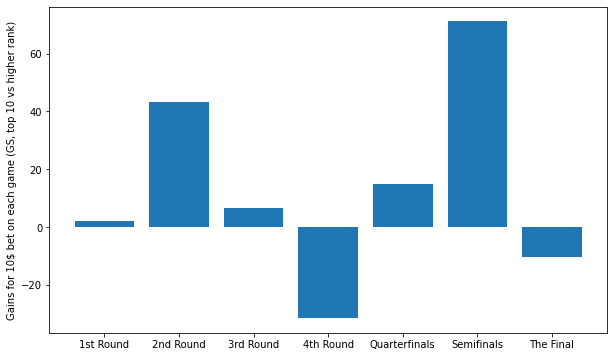

In [28]:
plt.rcParams['figure.figsize'] = [10, 6]
# show total gains per round in grand slams for top 10 players against theoretically weakest players
plt.bar(round,gains)
plt.ylabel("Gains for 10$ bet on each game (GS, top 10 vs higher rank)")
plt.show()

The data indicates that highest gains are made when betting with the odds in 2nd round and Semifinals. In 2nd round, top 10 players are generally opposed to much higher ranked players (ranked 50-100), explaining why the odds are lower than in semifinals where top 10 players are expected and therefore playing against each others, reason why the odds are higher and gains as well (despite the fact there are only 2 semifinals per tournament, compared to normally 10 matches in 2nd round for top 10 players)

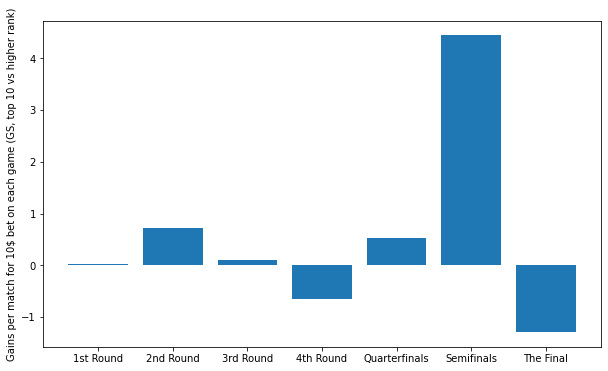

In [29]:
plt.bar(round,gainspermatch)
# show gain per match per round in grand slams for top 10 players against theoretically weakest players
plt.ylabel("Gains per match for 10$ bet on each game (GS, top 10 vs higher rank)")
plt.show()

For the reasons explained above, this data shows clearly confirms that the gain per match is much higher for semifinals than 2nd round.

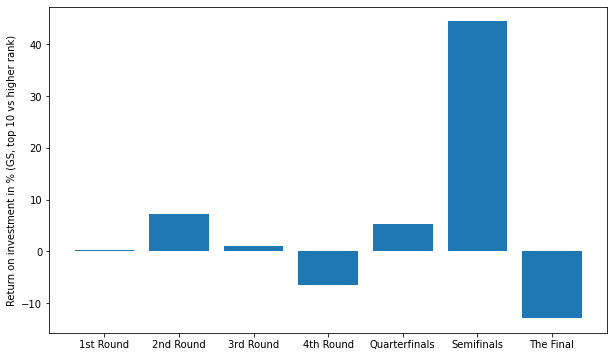

In [30]:
plt.bar(round,roi)
# show return on investment per round in grand slams for top 10 players against theoretically weakest players
plt.ylabel("Return on investment in % (GS, top 10 vs higher rank)")
plt.show()

Considering the return on investment, it seems that semifinals are the best solution. However the risk is higher since there are less matches than in 2nd round for instance. The ROI is lower in 2nd round because of the lower odds, but the impact of one wrong bet is probably lower in the longer term.